In [1]:
#Librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Arbol de decision
from sklearn.tree import DecisionTreeClassifier


#Visualizacion del arbol
from sklearn.tree import export_graphviz

#Para el bosque aleatorio.
from sklearn.ensemble import RandomForestClassifier

In [6]:
#Importacion del dataset
dataset = pd.read_csv("framinghamClean.csv")
dataset.drop(["Unnamed: 0"], axis=1, inplace=True)
dataset
#dataset.shape

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,82.0,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


## Preparacion del modelo.

In [8]:
#Eleccion de variables
columnas = dataset.columns.values.tolist()
predictors = columnas[:15]
target = columnas[-1]

In [10]:
#Se hara una columna is_train
dataset["is_train"] = (np.random.uniform(0,1,len(dataset))<=0.75).astype(int)

(array([1010.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3230.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

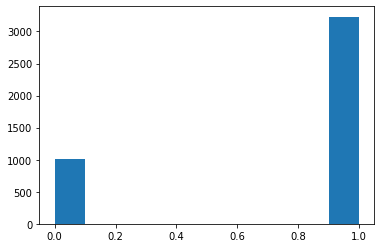

In [11]:
#Distribucion de los conjuntos, train, test.
plt.hist(dataset.is_train)

In [24]:
train, test = dataset[dataset["is_train"]==True], dataset[dataset["is_train"]==False]
len(train),len(test)

(3230, 1010)

In [13]:
tree = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, random_state=99)#Numero minimo para hacer division por defult es 2 pero genera overfitign, random_state=99 puede ser cualquiera
tree.fit(train[predictors], train[target])

DecisionTreeClassifier(criterion='entropy', min_samples_split=20,
                       random_state=99)

In [23]:
preds = tree.predict(test[predictors])
list(preds)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [15]:
pd.crosstab(test[target],preds,rownames=["Actual"],colnames=["Predictions"])

Predictions,0,1
Actual,,
0,766,81
1,140,23


## Visualizacion del arbol de decision

In [16]:
from sklearn.tree import export_graphviz

In [18]:
with open("/Users/antonioreyesguerrero/Desktop/DataS/ProyectosDataScience/Supervisados/framinghan/framinghan_three.dot", "w") as dotfile:
    export_graphviz(tree,out_file=dotfile, feature_names=predictors)
    dotfile.close()



In [19]:
import os
from graphviz import Source

In [20]:
file = open("/Users/antonioreyesguerrero/Desktop/DataS/ProyectosDataScience/Supervisados/framinghan/framinghan_three.dot","r")
text = file.read()

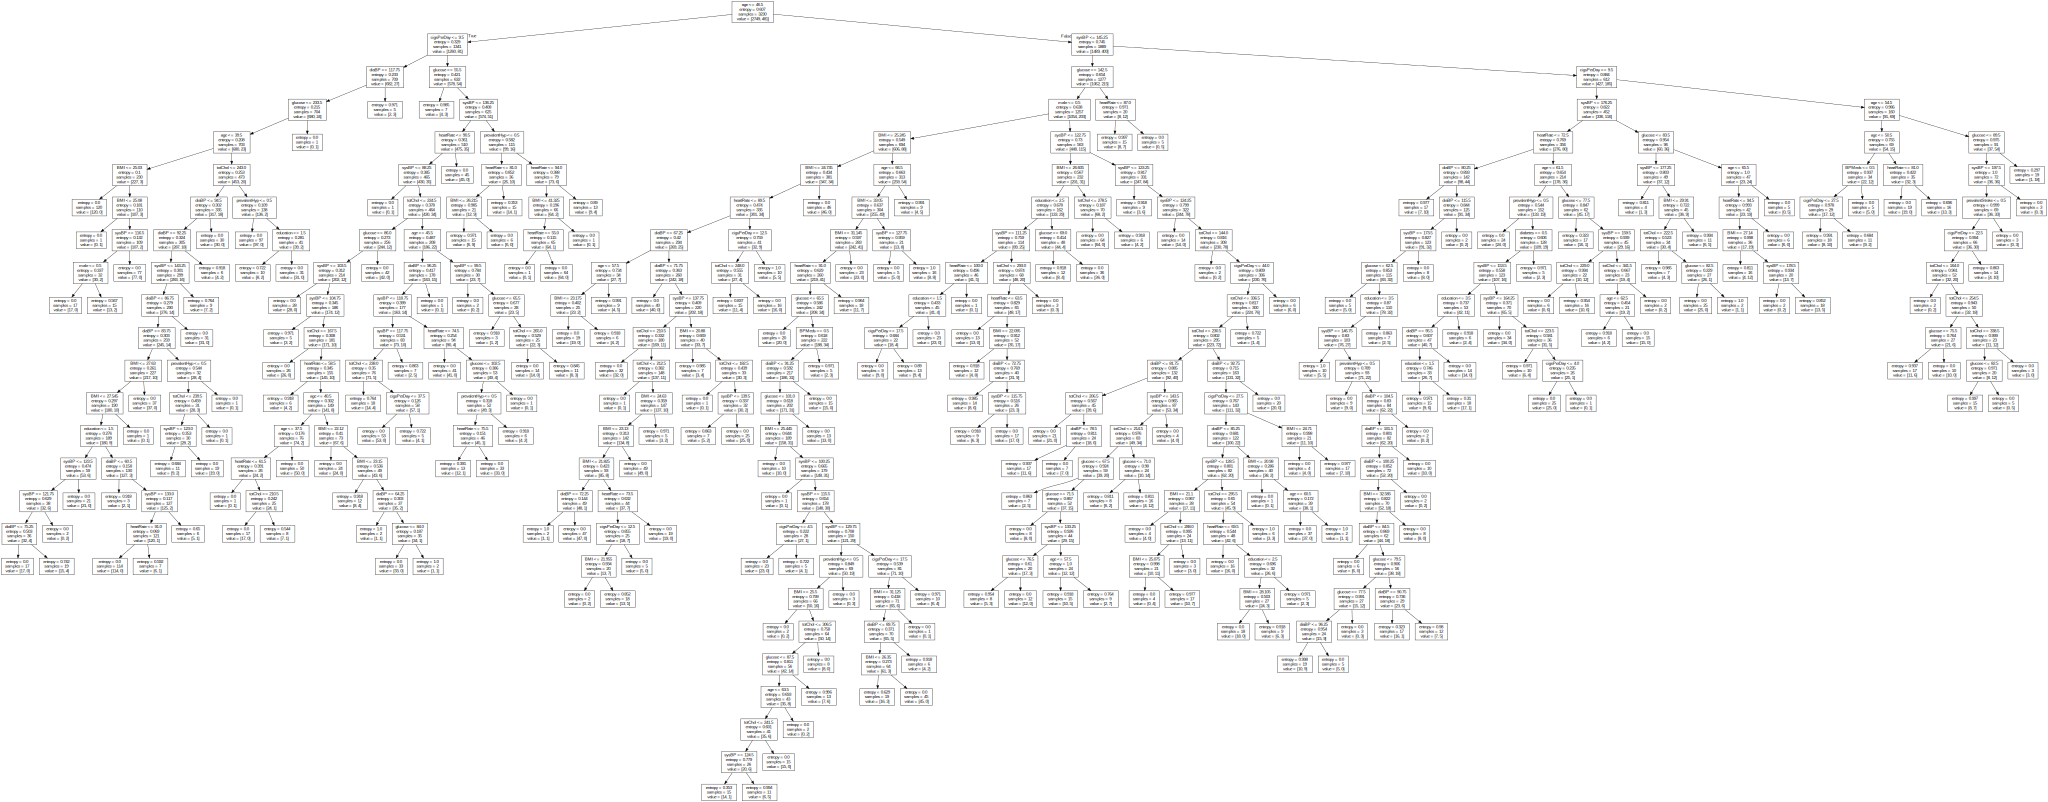

In [21]:
Source(text)